Available sequences: ['EHDP-00620_2020-05-19', 'EHDP-00620_2020-06-16', 'EHDP-00459_2020-04-29', 'EHDP-00619_2020-04-21', 'EHDP-00515_2020-02-28', 'EHDP-00461_2020-04-01', 'EHDP-00454_2020-04-01', 'EHDP-00089_2020-02-28', 'EHDP-00617_2020-04-21', 'EHDP-00460_2020-03-04', 'EHDP-00180_2019-11-13', 'EHDP-00374_2020-04-21', 'EHDP-00174_2019-11-13', 'EHDP-00454_2020-06-24', 'EHDP-00087_2020-02-28'] ...
--- Exploring EHDP-00620_2020-05-19 ---
Available datasets: ['combined', 'frame_indices', 'level_1_pooled', 'level_2_pooled', 'level_3_pooled', 'level_4_pooled', 'level_5_pooled', 'level_6_pooled', 'level_7_pooled', 'timestamps']
Metadata: {'cage_id': 'EHDP-00620', 'date': '2020-05-19', 'end_time': '2020-06-16T05:59:00', 'sequence_key': 'EHDP-00620_2020-05-19', 'start_time': '2020-05-19T06:00:00', 'total_frames': 40320}
Combined embedding shape: (40320, 1376)


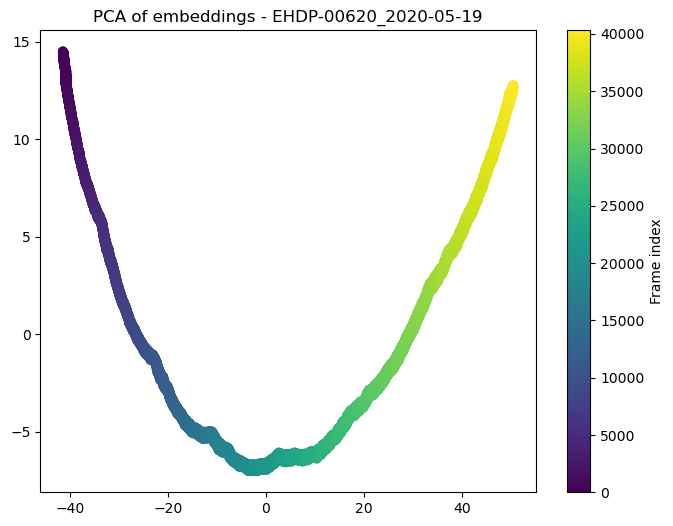

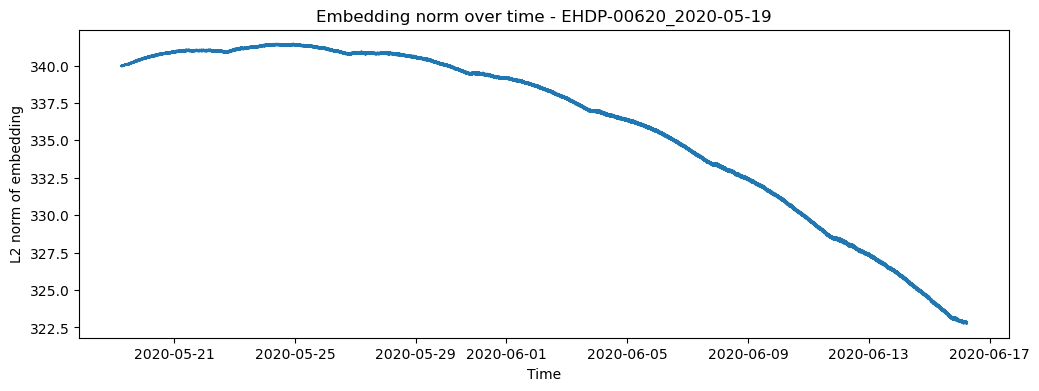

In [1]:
"""
Exploratory script for inspecting saved embeddings and timestamps.
"""

import os
from pathlib import Path
import zarr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# CONFIG
# -----------------------------
OUTPUT_DIR = Path("/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long")   # same as --output_dir in your main script
AGGREGATION = "4weeks"  # e.g. "10min", "1h", etc. -> one of your --aggregation_names
EMBEDDING_TYPE = "core_embeddings"  # or "spatial_embeddings"

# -----------------------------
# LOAD ONE SEQUENCE
# -----------------------------
def load_embedding_store(seq_key):
    """
    Load zarr store for a given sequence key (like 'EHDP-00083_2019-11-11').
    """
    path = OUTPUT_DIR / AGGREGATION / EMBEDDING_TYPE / f"{seq_key}.zarr"
    if not path.exists():
        raise FileNotFoundError(f"Store not found: {path}")
    
    store = zarr.open(path, mode='r')
    return store

# -----------------------------
# LIST AVAILABLE SEQUENCES
# -----------------------------
def list_sequences():
    seqs = []
    base = OUTPUT_DIR / AGGREGATION / EMBEDDING_TYPE
    if not base.exists():
        raise FileNotFoundError(f"No embeddings found at {base}")
    for f in os.listdir(base):
        if f.endswith(".zarr"):
            seqs.append(f.replace(".zarr", ""))
    return seqs

# -----------------------------
# INSPECT ONE SEQUENCE
# -----------------------------
def explore_sequence(seq_key):
    store = load_embedding_store(seq_key)

    print(f"--- Exploring {seq_key} ---")
    print("Available datasets:", list(store.array_keys()))
    print("Metadata:", dict(store.attrs))

    # Extract embeddings
    embeddings = {}
    for name in store.array_keys():
        if name in ["timestamps", "frame_indices"]:
            continue
        embeddings[name] = store[name][:]

    # Example: pick the "combined" embedding
    if "combined" in embeddings:
        emb = embeddings["combined"]
        print("Combined embedding shape:", emb.shape)

        # PCA / simple visualization
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        emb_2d = pca.fit_transform(emb)

        timestamps = store["timestamps"][:]
        plt.figure(figsize=(8,6))
        sc = plt.scatter(emb_2d[:,0], emb_2d[:,1], c=np.arange(len(emb_2d)), cmap="viridis")
        plt.colorbar(sc, label="Frame index")
        plt.title(f"PCA of embeddings - {seq_key}")
        plt.show()

    # Example: show embedding magnitude over time
    if "combined" in embeddings:
        norms = np.linalg.norm(embeddings["combined"], axis=1)
        ts = pd.to_datetime(store["timestamps"][:], format="%Y-%m-%d_%H:%M")
        # timestamp_strings = [ts.isoformat(timespec="minutes") for ts in timestamps]

        plt.figure(figsize=(12,4))
        plt.plot(ts, norms)
        plt.title(f"Embedding norm over time - {seq_key}")
        plt.xlabel("Time")
        plt.ylabel("L2 norm of embedding")
        plt.show()

# -----------------------------
# MAIN EXPLORATION LOOP
# -----------------------------
seqs = list_sequences()
print("Available sequences:", seqs[:15], "..." if len(seqs) > 5 else "")

if seqs:
    example_seq = seqs[0]
    explore_sequence(example_seq)

Embedding shape: (40320, 192)


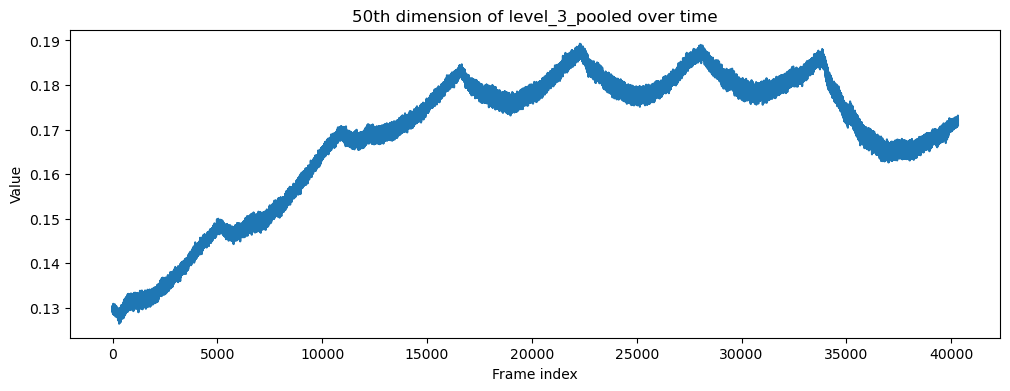

Explained variance ratio (first 5 PCs): [9.9184746e-01 6.7898002e-03 9.3416549e-04 2.2750774e-04 7.0428265e-05]


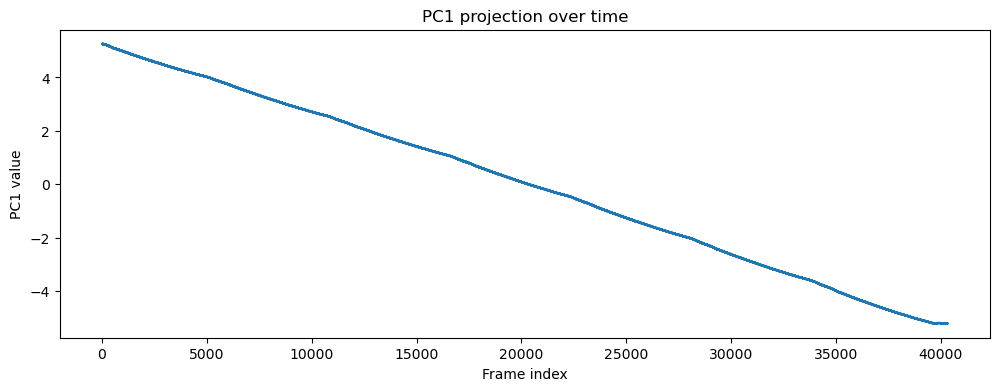

Top 10 contributing dimensions to PC1:
  dim 44 | loading 0.1774
  dim 185 | loading 0.1710
  dim 24 | loading -0.1673
  dim 11 | loading -0.1626
  dim 170 | loading 0.1533
  dim 140 | loading 0.1468
  dim 75 | loading 0.1441
  dim 183 | loading -0.1439
  dim 131 | loading -0.1399
  dim 126 | loading 0.1381


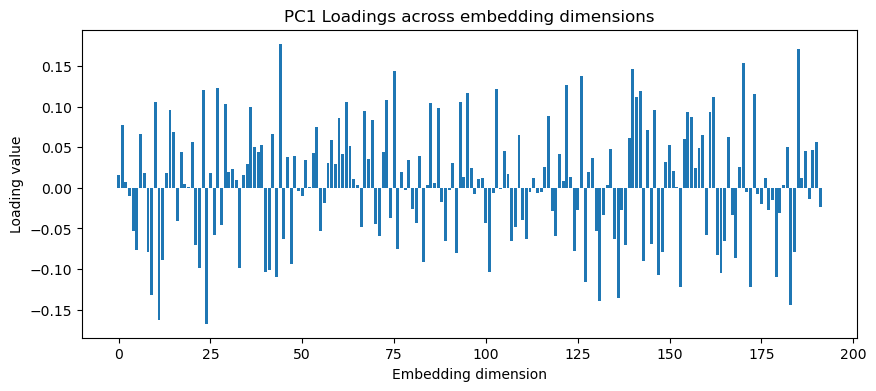

In [2]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

def analyze_level3(seq_key):
    store = load_embedding_store(seq_key)

    # 1. Access the level 3 embedding
    if "level_3_pooled" not in store:
        raise KeyError("No 'level_3_pooled' dataset in this sequence")
    emb = store["level_3_pooled"][:]  # shape: (frames, dim)

    print("Embedding shape:", emb.shape)

    # Example: access the 50th dimension (Python is 0-indexed → dim 49)
    dim50 = emb[:, 49]
    plt.figure(figsize=(12,4))
    plt.plot(dim50)
    plt.title("50th dimension of level_3_pooled over time")
    plt.xlabel("Frame index")
    plt.ylabel("Value")
    plt.show()

    # 2. Run PCA
    pca = PCA(n_components=5)
    emb_pca = pca.fit_transform(emb)
    print("Explained variance ratio (first 5 PCs):", pca.explained_variance_ratio_)

    # Plot PC1 projection over time
    plt.figure(figsize=(12,4))
    plt.plot(emb_pca[:,0])
    plt.title("PC1 projection over time")
    plt.xlabel("Frame index")
    plt.ylabel("PC1 value")
    plt.show()

    # 3. Look at contribution of original dimensions to PC1
    pc1_loadings = pca.components_[0]  # shape: (dim,)
    abs_loadings = np.abs(pc1_loadings)

    # Get top contributing dimensions
    top_dims = np.argsort(abs_loadings)[::-1][:10]
    print("Top 10 contributing dimensions to PC1:")
    for d in top_dims:
        print(f"  dim {d} | loading {pc1_loadings[d]:.4f}")

    # Visualize loadings
    plt.figure(figsize=(10,4))
    plt.bar(np.arange(len(pc1_loadings)), pc1_loadings)
    plt.title("PC1 Loadings across embedding dimensions")
    plt.xlabel("Embedding dimension")
    plt.ylabel("Loading value")
    plt.show()

# Example usage:
analyze_level3(example_seq)


### Split embeddings

In [3]:
import pandas as pd
import numpy as np
from datetime import time

def split_day_night_embeddings(seq_key, summary_df):
    store = load_embedding_store(seq_key)

    # Get embeddings and timestamps
    emb = store["level_3_pooled"][:]   # (frames, dim)
    ts = pd.to_datetime(store["timestamps"][:], format="%Y-%m-%d_%H:%M")

    # Find the matching summary row for this cage_id
    # cage_id can be obtained from the cage_id key in the embedding
    cage_id = store.attrs.get("cage_id", None)
    print(f"Processing cage_id: {cage_id}")
    row = summary_df.loc[summary_df["cage_id"] == cage_id].iloc[0]
    age_days = row["avg_age_days_chunk_start"]

    # Define masks for day/night
    hours = ts.hour
    day_mask = (hours >= 6) & (hours < 18)
    night_mask = ~day_mask

    # Split embeddings
    day_embeddings = emb[day_mask]
    night_embeddings = emb[night_mask]

    print(f"Cage {cage_id}: {day_embeddings.shape[0]} day frames, {night_embeddings.shape[0]} night frames")

    return {
        "cage_id": cage_id,
        "age_days": age_days,
        "day_embeddings": day_embeddings,
        "night_embeddings": night_embeddings,
        "day_timestamps": ts[day_mask],
        "night_timestamps": ts[night_mask]
    }

# Example usage:
summary_df = pd.read_csv("/scratch/bhole/dvc_data/smoothed/40320/summary_metadata_40320.csv")  # adapt if it's parquet/hdf5
result = split_day_night_embeddings(example_seq, summary_df)

day_embeddings = result["day_embeddings"]
night_embeddings = result["night_embeddings"]

Processing cage_id: EHDP-00620
Cage EHDP-00620: 20160 day frames, 20160 night frames


### Train age predictor separately

In [4]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

# Prepare day and night data
X_day, y_day = day_embeddings, np.full(len(day_embeddings), result["age_days"])
X_night, y_night = night_embeddings, np.full(len(night_embeddings), result["age_days"])

# --- Day embeddings ---
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(
    X_day, y_day, test_size=0.2, random_state=42
)

clf_day = Ridge(alpha=1.0)
clf_day.fit(X_train_day, y_train_day)
y_pred_day = clf_day.predict(X_test_day)

print("Day embeddings - R^2:", r2_score(y_test_day, y_pred_day))
print("Day embeddings - RMSE:", root_mean_squared_error(y_test_day, y_pred_day))

# --- Night embeddings ---
X_train_night, X_test_night, y_train_night, y_test_night = train_test_split(
    X_night, y_night, test_size=0.2, random_state=42
)

clf_night = Ridge(alpha=1.0)
clf_night.fit(X_train_night, y_train_night)
y_pred_night = clf_night.predict(X_test_night)

print("Night embeddings - R^2:", r2_score(y_test_night, y_pred_night))
print("Night embeddings - RMSE:", root_mean_squared_error(y_test_night, y_pred_night))

Day embeddings - R^2: 1.0
Day embeddings - RMSE: 0.0
Night embeddings - R^2: 1.0
Night embeddings - RMSE: 0.0


Total day frames: 161280, Total night frames: 161280


/home/bhole/miniforge3/envs/behavemae/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.22146e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/bhole/miniforge3/envs/behavemae/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.27498e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


=== DAY EMBEDDINGS ===
R^2: 0.9562416458126712
RMSE: 4.007481379904172

=== NIGHT EMBEDDINGS ===
R^2: 0.9617718565528328
RMSE: 3.7456968610235144


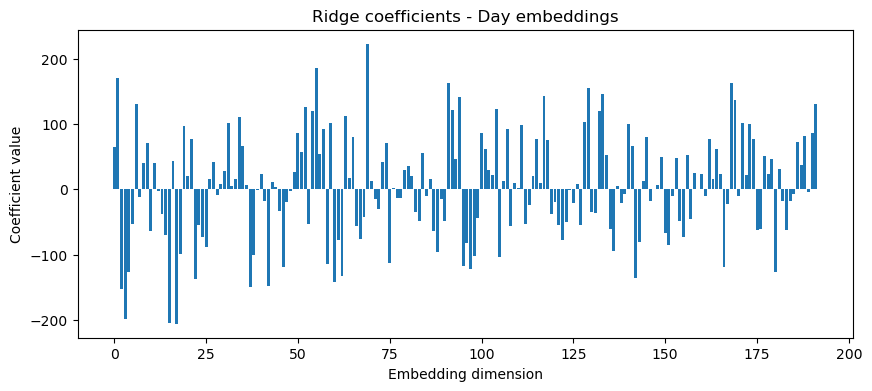

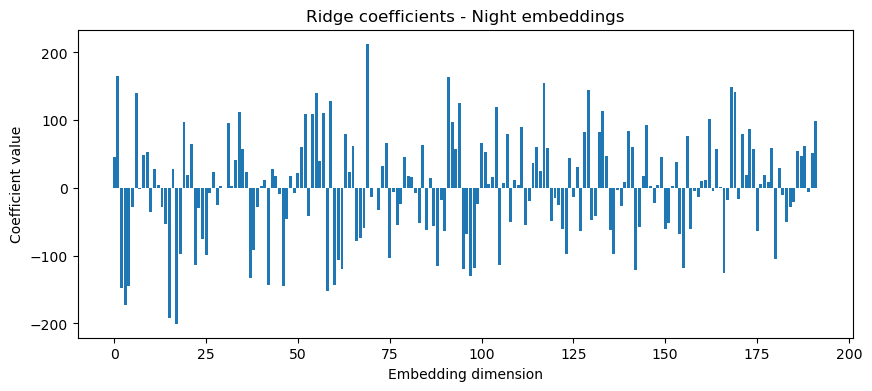

In [5]:
import zarr
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, root_mean_squared_error

# --- CONFIG ---
zarr_files = [
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00083_2020-02-28.zarr",
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00084_2020-02-28.zarr",
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00085_2020-02-28.zarr",
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00086_2020-02-28.zarr",
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00087_2020-02-28.zarr",
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00088_2020-02-28.zarr",
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00089_2020-02-28.zarr",
    "/scratch/bhole/dvc_data/smoothed/models_4weeks/extract_opt_long/4weeks/core_embeddings/EHDP-00090_2020-02-28.zarr",
    # add up to 10
]
summary_csv = "/scratch/bhole/dvc_data/smoothed/40320/summary_metadata_40320.csv"

DAY_START = 6
DAY_END = 18

# --- LOAD SUMMARY ---
summary_df = pd.read_csv(summary_csv)
summary_df["cage_id"] = summary_df["cage_id"].astype(str).str.strip()

# --- HELPER: Load and split day/night ---
def load_split_embeddings(zarr_path, summary_df, level="level_3_pooled"):
    store = zarr.open(zarr_path, mode='r')
    
    cage_id = store.attrs.get("cage_id")
    ts = pd.to_datetime(store["timestamps"][:], format="%Y-%m-%d_%H:%M")
    emb = store[level][:]  # (frames, dim)
    
    # Get age
    matching = summary_df.loc[summary_df["cage_id"] == cage_id]
    if matching.empty:
        print(f"Warning: cage_id {cage_id} not found in summary")
        return None, None, None, None
    age_days = matching.iloc[0]["avg_age_days_chunk_start"]
    
    # Day/night masks
    hours = ts.hour
    day_mask = (hours >= DAY_START) & (hours < DAY_END)
    night_mask = ~day_mask
    
    return (
        emb[day_mask], np.full(np.sum(day_mask), age_days),
        emb[night_mask], np.full(np.sum(night_mask), age_days)
    )

# --- AGGREGATE ALL SEQUENCES ---
X_day_list, y_day_list = [], []
X_night_list, y_night_list = [], []

for zfile in zarr_files:
    day_emb, day_age, night_emb, night_age = load_split_embeddings(zfile, summary_df)
    if day_emb is None:
        continue
    X_day_list.append(day_emb)
    y_day_list.append(day_age)
    X_night_list.append(night_emb)
    y_night_list.append(night_age)

# Concatenate across sequences
X_day = np.vstack(X_day_list)
y_day = np.concatenate(y_day_list)
X_night = np.vstack(X_night_list)
y_night = np.concatenate(y_night_list)

print(f"Total day frames: {X_day.shape[0]}, Total night frames: {X_night.shape[0]}")

# --- TRAIN/TEST SPLIT ---
X_train_day, X_test_day, y_train_day, y_test_day = train_test_split(
    X_day, y_day, test_size=0.2, random_state=42
)
X_train_night, X_test_night, y_train_night, y_test_night = train_test_split(
    X_night, y_night, test_size=0.2, random_state=42
)

# --- MODEL ---
clf_day = Ridge(alpha=1.0)
clf_day.fit(X_train_day, y_train_day)
y_pred_day = clf_day.predict(X_test_day)

clf_night = Ridge(alpha=1.0)
clf_night.fit(X_train_night, y_train_night)
y_pred_night = clf_night.predict(X_test_night)

# --- METRICS ---
print("=== DAY EMBEDDINGS ===")
print("R^2:", r2_score(y_test_day, y_pred_day))
print("RMSE:", root_mean_squared_error(y_test_day, y_pred_day))

print("\n=== NIGHT EMBEDDINGS ===")
print("R^2:", r2_score(y_test_night, y_pred_night))
print("RMSE:", root_mean_squared_error(y_test_night, y_pred_night))

# Optional: inspect which embedding dimensions contribute most to the predictions
coef_day = clf_day.coef_
coef_night = clf_night.coef_

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.bar(np.arange(len(coef_day)), coef_day)
plt.title("Ridge coefficients - Day embeddings")
plt.xlabel("Embedding dimension")
plt.ylabel("Coefficient value")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(np.arange(len(coef_night)), coef_night)
plt.title("Ridge coefficients - Night embeddings")
plt.xlabel("Embedding dimension")
plt.ylabel("Coefficient value")
plt.show()
